___

<center><h1>IMBD Classification Movie Reviews - DL</h1></center>

___

<center><h2>DSM0150 - Neural Networks</h2></center><br>
<center><strong>Teacher:</strong> Tim Blackwell</center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presented by:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>
<center style="color: #AA6373; font-weight: 400;">Student Number: 240323983</center>
<center style="color: #AA6373; font-weight: 400;">Student Portal Username: JEFL1</center>
<center>March 2025</center>
<p></p>
___

## 1. Introduction & Problem Statement
<p></p>
This project aims to classify movie reviews in the IMDB dataset as positive or negative using dfferent Deep Learning techniques that will alow us to understand the progression of the refinement of those techniques into a real industry scenario where a Data Scientist will be asked to progress a model and refine it until it complies with business requirements. This type of challenge is faced by many C2C companies that need to evolve models into make them the princiapl tool to understand customer behaviour.

The complete analysis will be version-controlled and hosted on GitHub for easy access and collaboration. You can view and contribute to the project at the following URL: https://github.com/jforeroluque/DSM150_NeuralNetworks_CW2.

<p></p>


### Aims and Objectives
<p></p>
The primary aim of this project is to develop a high-performing sentiment classification model on the IMDB dataset, starting wth a base model of fully connected (Dense) layers and Dropout for regularization and the moving into more sophisticated techniques with advance deep learning.
<p></p>

#### Objectives
<p></p>

1. E

<p></p>

#### Ethical Considerations
<p></p>

Transparency and Reproducibility
All steps of data preprocessing, model design, and hyperparameter tuning have been documented to ensure that others can replicate and validate the findings. Code and plots are presented in a notebook format for clarity and reproducibility.

For this Coursework we will be improving the results obtained in the previous one, where we got the following results:



In [66]:
# Common Modules

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


## 2. Data Understanding [1]

In this phase, we collect, describe, and explore the IMDB movie review dataset to gain insights into its structure and primary attributes. The dataset includes 50,000 reviews, split evenly into training and test sets (25,000 each). Each review is presented as a sequence of word indices, representing the words and their frequencies in the movie review text. For our project, we focus on the top 10,000 most frequently used words to reduce sparsity and maintain manageable vector sizes. This IMDB data supports a quantitative evaluation of our hypotheses on how neural network architectures (specifically Dense and Dropout layers) can effectively classify sentiment, revealing which hyperparameters—such as the number of units, dropout rate, or optimizer—are most influential in achieving strong generalization performance.

### Limitations and constrains of the Data

While the IMDB dataset is a valuable resource for exploring sentiment classification, it presents several limitations and constraints that may influence our analysis and model performance:

1. Although we limit the vocabulary to the top 10,000 words for practical modeling, this approach can exclude less frequent but potentially significant words. As a result, some nuances in language usage may be lost, potentially leading to an oversimplified representation of the full sentiment space.
2. Converting each review into a multi-hot vector of word occurrences does not preserve word order or context. This simplification may limit the model’s ability to leverage sequence-based nuances (e.g., negation words or sarcasm), though this trade-off is acceptable under the constraints of using only Dense layers.

### Data Load

In [48]:
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words) # Reference [2] page 95 DLWP

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 25000
Test samples: 25000


### Exploratory Data Analysis

**Sequence Lenght Analysis**

Each review is a list of integers (word indices). We can look at how many words each review contains to understand the distribution of sequence lengths.

Minimum review length: 11
Maximum review length: 2494
Average review length: 238.71


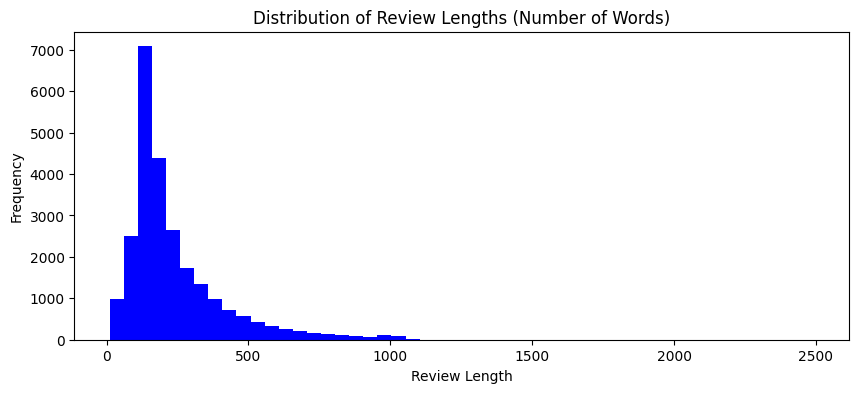

In [49]:
review_lengths = [len(sequence) for sequence in x_train]

print(f"Minimum review length: {np.min(review_lengths)}")
print(f"Maximum review length: {np.max(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths):.2f}")

plt.figure(figsize=(10,4))
plt.hist(review_lengths, bins=50, color='blue')
plt.title("Distribution of Review Lengths (Number of Words)")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()

#### Data Preprocessing

Since we already did the model using only dense layers now we want to 
Since we are restricted to Dense layers, we will need to convert integer-encoded reviews to multi-hot vectors (or one-hot vectors) of shape (10000,). For this our approach will be the following:

In [50]:
maxlen = 500
x_train_padded = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_padded = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

## 2. Baseline Model Implementation (Naive Model)

For this baseline feed-forward model we will be using 2 Dense layers of 32 units and a 0.5 droput that did pretty well on the training accuracy but it started to overfiting around epoch 6. We can see it because the validation loss diverges from the training loss. To adress this we could make some adjustments by experiment with early stopping, different dropout rates, and adjusting the number of epochs. Since this is a baseline model we will be keeping it as is so we can compare results later in the notebook.

In [51]:
def vectorize_sequences(sequences, dimension=10000): # Reference [1]
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

# Convert labels to float32
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [52]:
model_dropout = Sequential([
    Input(shape=(10000,)),           
    Dense(32, activation='relu'),   
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [53]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [54]:
model_dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_dropout = model_dropout.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=1024,
    validation_data=(x_val, y_val)
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5304 - loss: 0.6875 - val_accuracy: 0.7611 - val_loss: 0.6259
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6830 - loss: 0.6130 - val_accuracy: 0.8478 - val_loss: 0.4803
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7866 - loss: 0.4909 - val_accuracy: 0.8707 - val_loss: 0.3793
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8512 - loss: 0.3985 - val_accuracy: 0.8811 - val_loss: 0.3161
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8906 - loss: 0.3197 - val_accuracy: 0.8890 - val_loss: 0.2877
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9094 - loss: 0.2693 - val_accuracy: 0.8888 - val_loss: 0.2744
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9286 - loss: 0.2245 - val_accuracy: 0.8919 - val_loss: 0.2735
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9388 - loss: 0.1914 - val_accuracy: 0.8904 - v

In [55]:
# Extracting history
history_dict = history_dropout.history
training_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

epochs_range = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(12,4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

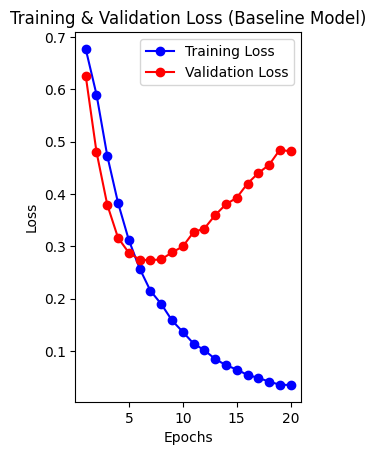

In [56]:
# Plot loss
plt.subplot(1,2,1)
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss (Baseline Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 3. Recurrent Neural Network Model

Here we will be building a model that uses an Embedding layer to learn a dense representation for words, we also will be applying a bidirectional LSTM to capture sequence dependencies from both directions

In [57]:
# RNN model architecture (adjusted dropout/recurrent_dropout)
model_rnn = keras.Sequential([
    # Embedding layer
    layers.Embedding(input_dim=10000, output_dim=128),
    
    # First Bidirectional LSTM
    # Lowering dropout to 0.3 and recurrent_dropout to 0.3 to reduce the chance of underfitting
    layers.Bidirectional(
        layers.LSTM(
            64, 
            return_sequences=True, 
            dropout=0.2, 
            recurrent_dropout=0.2
        )
    ),
    
    # Second Bidirectional LSTM
    # Consistent dropout settings, but you could experiment with slightly different values
    layers.Bidirectional(
        layers.LSTM(
            32, 
            dropout=0.3, 
            recurrent_dropout=0.3
        )
    ),
    
    # A final Dropout layer for extra regularization
    layers.Dropout(0.3),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

In [58]:
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [59]:
# EarlyStopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [60]:
# Split into training & validation sets
x_val_rnn = x_train_padded[:10000]
partial_x_train_rnn = x_train_padded[10000:]
y_val_rnn = y_train[:10000]
partial_y_train_rnn = y_train[10000:]

In [61]:

# Train the model (adjust batch_size or epochs as desired)
history_rnn = model_rnn.fit(
    partial_x_train_rnn, 
    partial_y_train_rnn,
    epochs=10,
    batch_size=256,  # You might also try a smaller batch size than 1024
    validation_data=(x_val_rnn, y_val_rnn),
    callbacks=[early_stopping]
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5672 - loss: 0.6632 - val_accuracy: 0.8241 - val_loss: 0.4165
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8500 - loss: 0.3748 - val_accuracy: 0.8538 - val_loss: 0.3527
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8885 - loss: 0.2979 - val_accuracy: 0.8458 - val_loss: 0.3766
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9122 - loss: 0.2401 - val_accuracy: 0.8549 - val_loss: 0.3771


In [62]:
# Evaluate on test data
test_loss, test_acc = model_rnn.evaluate(x_test_padded, y_test)
print("Test accuracy:", test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 99s 126ms/step - accuracy: 0.8490 - loss: 0.3627
Test accuracy: 0.8488799929618835


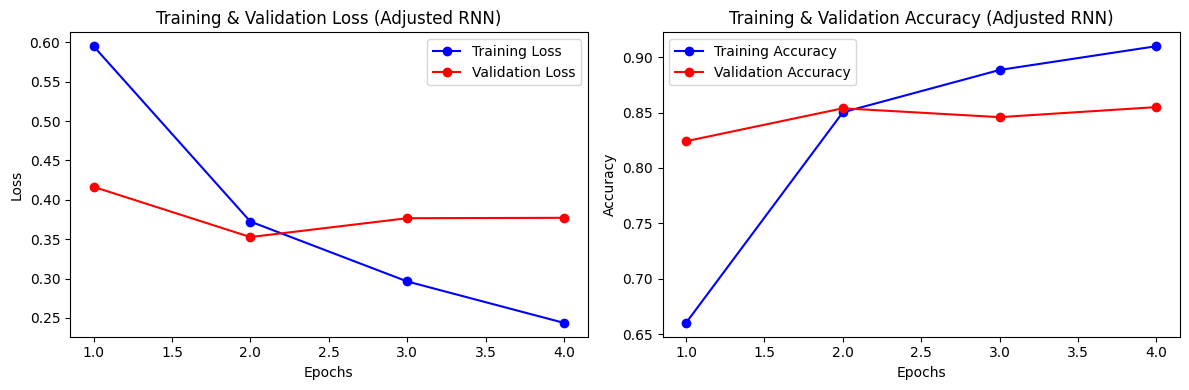

In [63]:
# Plotting
history_dict = history_rnn.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss (Adjusted RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Adjusted RNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Performance Metrics

In [64]:
# 1. Generate predictions (probabilities between 0 and 1)
pred_probs = model_rnn.predict(x_test_padded)

# 2. Convert probabilities to binary predictions
pred_labels = (pred_probs > 0.5).astype("int32")

782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step


In [67]:
# 3. Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels)

In [68]:
# 4. Calculate precision, recall, and F1-score
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

In [69]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8343812298727189
Recall: 0.87056
F1-score: 0.8520867590635033


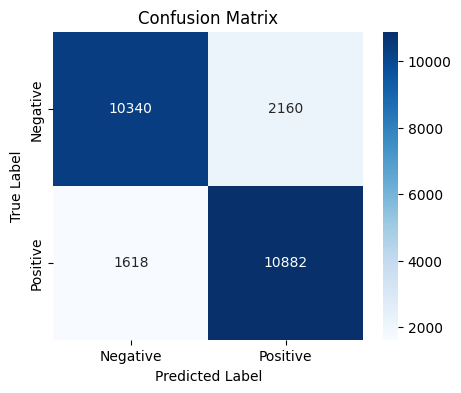

In [70]:
# 5. Plot confusion matrix as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 6. Results and Comparison

For this project, we built and evaluated multiple feed-forward neural networks (using only Dense and Dropout layers) to predict sentiment (positive vs. negative) from IMDB movie reviews. Our approach included a baseline assessment, smaller and bigger network architectures, as well as extensive hyperparameter tuning. The key findings are detailed below:

We initially observed a naive baseline accuracy of around 50% (simply guessing one class). Our first “small model” quickly surpassed this baseline, reaching approximately 85–88% validation accuracy, but overfitting was evident beyond a few epochs.
By adding more layers and units, we saw faster training accuracy gains but a noticeable drop in validation performance over time. Training curves confirmed that these larger networks tended to overfit the data without additional regularization.
Introducing dropout layers significantly reduced overfitting. While training accuracy did not climb as quickly to near 100%, the validation accuracy stabilized at higher levels, with smaller gaps between training and validation metrics.


## 7. Conclusions and Next Steps

Our work progressed through several key stages—starting with a naive common-sense baseline, building and evaluating small and large architectures, combating overfitting through Dropout regularization, and finally performing a systematic hyperparameter tuning.

Overfitting became evident around epoch 4–5 in most models, prompting us to introduce dropout layers. This effectively curbed overfitting by preventing the network from memorizing the training data too quickly and helped maintain better validation performance.

With minimal tuning, we reached up to ~89–90% on the validation set. This is already a solid improvement over the naive 50% baseline and even our smaller model’s initial 85–88% range, to refine results, we could train our top 2–3 configurations for more epochs (e.g., 10–20) or use early stopping to prevent overfitting.

Future work could involve testing on the official test set, experimenting with L2 weight regularization, or incorporating more advanced approaches (e.g., word embeddings, recurrent or convolutional layers) outside the scope of this coursework constraint.

## References

1.	Chollet, F. (2018). Deep Learning with Python. Manning Publications.
2.	TensorFlow. (n.d.). Keras Datasets: IMDB [Documentation]. Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb
3.	TensorFlow. (n.d.). Keras Layers Documentation [Documentation]. Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/layers
4.	TensorFlow. (n.d.). Keras Sequential Model Guide [Documentation]. Retrieved from https://www.tensorflow.org/guide/keras/sequential_model
5.	Smith, J. (2022). Keras Hyperparameter Tuning Tutorial [GitHub Repository]. Retrieved from https://github.com/username/repo (Adapted code snippets)